In [4]:
import codecs
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
import json
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
import torch
from torch.cuda.amp import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import yaml

from config import Config

In [5]:
seed = 2022
val_ratio = 0.2

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
vocab_dim = 512  # 词向量维度
maxlen = 20  # 序列最大长度
n_iterations = 50  # 迭代次数
n_exposures = 5  # 词频截断值
window_size = 5  # 窗口大小
batch_size = 32  # 批次大小
n_epoch = 25  # 迭代次数
input_length = 20  # 输入序列长度
cpu_count = multiprocessing.cpu_count()  #
window_sizes = [3, 3, 5, 7]

In [8]:
def load_file():
    """加载数据"""
    # 加载数据集
    null = pd.read_csv(Config.Emotion_List[0], header=None, index_col=None)  # null
    like = pd.read_csv(Config.Emotion_List[1], header=None, index_col=None)  # like
    sad = pd.read_csv(Config.Emotion_List[2], header=None, index_col=None)  # sad
    disgust = pd.read_csv(Config.Emotion_List[3], header=None, index_col=None)  # disgust
    anger = pd.read_csv(Config.Emotion_List[4], header=None, index_col=None)  # anger
    happy = pd.read_csv(Config.Emotion_List[5], header=None, index_col=None) # happy


    null = [row[0].split() for row in null.values]
    like = [row[0].split() for row in like.values]
    sad = [row[0].split() for row in sad.values]
    disgust = [row[0].split() for row in disgust.values]
    anger = [row[0].split() for row in anger.values]
    happy = [row[0].split() for row in happy.values]

    # 拼接
    x = null + like + sad + disgust + anger + happy
    print(type(x))
    # null-0 like-1 sad-2 disgust-3 anger-4 happy-5
    y = np.concatenate((np.zeros(len(null), dtype=int), np.ones(len(like), dtype=int),
                        np.ones(len(sad), dtype=int) * 2, np.ones(len(disgust), dtype=int) * 3,
                        np.ones(len(anger), dtype=int) * 4, np.ones(len(happy), dtype=int) * 5))

    return x, y

In [9]:
def create_dictionaries(model=None, combined=None):
    """创建词语字典，并返回每个词语的索引，词向量，以及每个句子所对应的词语索引"""
    if (combined is not None) and (model is not None):
        if os.path.exists(Config.combined_path) and os.path.exists(Config.w2vec_path) and os.path.exists(
                Config.w2indx_path):  # 已写入
            print("加载词典")
            w2indx_json = codecs.open(Config.w2indx_path, 'r', encoding=Config.encoding)
            w2vec_json = codecs.open(Config.w2vec_path, 'r', encoding=Config.encoding)
            combined_json = codecs.open(Config.combined_path, 'r', encoding=Config.encoding)

            w2indx = json.load(w2indx_json)
            W2VEC = json.load(w2vec_json)  # 加载的数组为list，需转换为numppy数组
            combined = np.loadtxt(combined_json, dtype=int)

            # 转换
            w2vec = dict()
            for key, value in W2VEC.items():
                w2vec[key] = np.asarray(value)

            w2indx_json.close()
            w2vec_json.close()
            combined_json.close()

            return w2indx, w2vec, combined
        else:
            gensim_dict = Dictionary()  # 创建一个空的词典,构建 word<->id 映射
            gensim_dict.doc2bow(list(model.wv.index_to_key),
                                allow_update=True)  # 构建词袋，每个单词对应一个id，词袋中的单词不重复
            w2indx = {v: k + 1 for k, v in gensim_dict.items()}  # 所有频数超过10的词语的索引字典
            w2vec = {word: model.wv[word] for word in w2indx.keys()}  # 所有频数超过10的词语的词向量字典
            W2VEC = {word: model.wv[word].tolist() for word in w2indx.keys()}  # 将numpy数组转换为list存储

            def parse_dataset(combined):
                """将combined中的数据转换为索引表示"""
                data = []
                for sentence in combined:
                    new_txt = []
                    for word in sentence:
                        try:
                            new_txt.append(w2indx[word])
                        except:
                            new_txt.append(0)
                    new_txt=torch.Tensor(new_txt[:maxlen]).int()
                    data.append(new_txt)
                return data

            combined = parse_dataset(combined)  # 将combined中的数据转换为索引表示
            combined = nn.utils.rnn.pad_sequence(combined, batch_first=True, padding_value=0)
            # 每个句子所含词语对应的索引，所以句子中含有频数小于10的词语，索引为0

            w2indx_json = codecs.open(Config.w2indx_path, 'w', encoding=Config.encoding)
            w2vec_json = codecs.open(Config.w2vec_path, 'w', encoding=Config.encoding)
            combined_json = codecs.open(Config.combined_path, 'w', encoding=Config.encoding)

            json.dump(w2indx, w2indx_json)
            json.dump(W2VEC, w2vec_json)
            np.savetxt(combined_json, combined)  # numpy.ndarrayi

            w2indx_json.close()
            w2vec_json.close()
            combined_json.close()

            return w2indx, w2vec, combined
    else:
        print('No data provided...')

In [10]:
def word2vec_train(combined):
    """创建词语字典，并返回每个词语的索引，词向量，以及每个句子所对应的词语索引"""
    # size：是指特征向量的维度  min_count:对字典做截断. 词频少于min_count次数的单词会被丢弃掉
    # window：表示当前词与预测词在一个句子中的最大距离是多少  workers：参数控制训练的并行数。
    # iter： 迭代次数，默认为5
    print(combined[:10])
    if not os.path.exists(Config.word2vec_path):
        print(111)
        model = Word2Vec(
            sentences=combined,
            vector_size=vocab_dim,
            min_count=n_exposures,
            window=window_size,
            workers=cpu_count,
            epochs=n_iterations)
        model.save(Config.word2vec_path)  # 保存模型
    else:
        print("load word2vec model")
        model = Word2Vec.load(Config.word2vec_path)

    index_dict, word_vectors, combined = create_dictionaries(model=model, combined=combined)
    return index_dict, word_vectors, combined

In [11]:
def get_data(index_dict, word_vectors, combined, y):
    n_symbols = len(index_dict) + 1  # 所有单词的索引数，频数小于10的词语索引为0，所以加1
    embedding_weights = np.zeros((n_symbols, vocab_dim))  # 索引为0的词语，词向量全为0
    for word, index in index_dict.items():  # 从索引为1的词语开始，对每个词语对应其词向量
        embedding_weights[index, :] = word_vectors[word]
    x_train, x_test, y_train, y_test = train_test_split(combined, y, test_size=0.2)

    print(f"train {x_train.shape}, test {x_test.shape}")

    return n_symbols, embedding_weights, x_train, y_train, x_test, y_test

In [12]:
class MYDataset(Dataset):
    def __init__(self, x, y, index_dict, word_vectors):
        self.x = x
        self.y = y
        self.n_symbols = len(index_dict) + 1  # 所有单词的索引数，频数小于10的词语索引为0，所以加1
        self.embedding_weights = np.zeros((self.n_symbols, vocab_dim))  # 索引为0的词语，词向量全为0

        for word, index in index_dict.items():  # 从索引为1的词语开始，对每个词语对应其词向量
            self.embedding_weights[index, :] = word_vectors[word]

    def __getitem__(self, idx):
        labels = torch.zeros(6)
        labels[self.y[idx]] = 1

        # print(self.x[idx])
        return self.embedding_weights[self.x[idx]], labels

    def __len__(self):
        return len(self.x)

In [13]:
class TextCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=vocab_dim,
                                        out_channels=256,
                                        kernel_size=h),
                              nn.Dropout(0.2),
                              nn.BatchNorm1d(num_features=256),
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=maxlen-h+1))
                     for h in window_sizes
                    ])
        self.fc = nn.Linear(in_features=256 * len(window_sizes),
                            out_features=6)

    def forward(self, x):
        # inputs = [batch, maxlen, vocab_dim]

        # SpatialDropout1D
        x = x.permute(0, 2, 1)   #  [batch, vocab_dim, maxlen]
        x = F.dropout2d(x, 0.3, training=self.training)
        x = x.permute(0, 2, 1)   # back to  [batch, maxlen, vocab_dim]

        # batch_size x text_len x embedding_size  -> batch_size x embedding_size x text_len
        x = x.permute(0, 2, 1)

        out = torch.cat([conv(x).squeeze(-1) for conv in self.convs], dim=1)
        out = self.fc(out)

        return out

In [14]:
# 训练模型，并保存
print('Loading Data...')
combined, y = load_file()
print(len(combined), len(y))

print('Training a Word2vec model...')
index_dict, word_vectors, combined = word2vec_train(combined)

print("get data and labels")
dataset = MYDataset(combined, y, index_dict, word_vectors)

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) # (1735017, 433754)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Loading Data...
<class 'list'>
2168771 2168771
Training a Word2vec model...
[['又', '翠湖', "'", '？', '呀', '秋', '哥', "'", '你', '讲', '过', '好多', '次', '了'], ['无非', '是', '那', '两', '个', '人', '吧', '…'], ['义工', '是', '做', '什么', '的', '嫩'], ['围', '湖', '跑', '吗', '，', '大概', '是', '几', '圈'], ['没有', '二', '次', '基本', '没有', '后期', '调整'], ['组团', '儿', '去', '当', '尼姑', '吧'], ['新', '电影', '1', '月', '1', '号', '上', '，', '专辑', '年底', '制作', '。'], ['跟', '安藤', '有的', '一', '拼', '啦', '！'], ['听说', '点', '，', '我家', '那边', '就是', '主', '战场'], ['星期', '一', '到', '北京', '。']]
load word2vec model
加载词典
get data and labels


In [15]:
model = TextCNN()
model.cuda()

TextCNN(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): Dropout(p=0.2, inplace=False)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaxPool1d(kernel_size=18, stride=18, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): Dropout(p=0.2, inplace=False)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaxPool1d(kernel_size=18, stride=18, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(5,), stride=(1,))
      (1): Dropout(p=0.2, inplace=False)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to('cuda')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.4)  # reduce the learning after 20 epochs by a factor of 10

In [74]:
def train(model, epoch):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    with tqdm(train_loader, unit="batch") as tepoch: # 🌟 1. 定义进度条
        for inputs, labels in tepoch:   # 🌟 2. 设置迭代器
            tepoch.set_description(f"Epoch {epoch} train: ") # 🌟 3. 设置开头

            inputs, labels = inputs.type(torch.cuda.FloatTensor).cuda(), labels.cuda()

            with autocast():
                outputs = model(inputs)
                # print(outputs, labels)
                loss = loss_fn(outputs, labels)
                correct = (outputs.argmax(axis=1) == labels.argmax(axis=1)).sum().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += correct

        train_acc = epoch_acc / len(train_loader.dataset)
        # print(epoch_acc, len(train_loader.dataset))
        train_loss = epoch_loss / len(train_loader.dataset)

        tepoch.write("Train Epoch: {} Train Loss: {:.6f} Train Acc: {:.6f}".format(epoch, train_loss, train_acc))
        tepoch.close()

        return train_acc, train_loss

In [81]:
def test(model, epoch):
    epoch_loss = 0
    epoch_acc = 0
    model.eval() # set the model to evaluation mode
    with tqdm(val_loader, unit="batch") as vepoch: # 🌟 1. 定义进度条
        with torch.no_grad():
            for inputs, labels in vepoch:   # 🌟 2. 设置迭代器
                vepoch.set_description(f"Epoch {epoch} val: ") # 🌟 3. 设置开头
                inputs, labels = inputs.type(torch.cuda.FloatTensor).cuda(), labels.cuda()

                outputs = model(inputs).squeeze(1)
                loss = loss_fn(outputs, labels)
                # 计算准确率
                correct = (outputs.argmax(axis=1) == labels.argmax(axis=1)).sum().item()

                epoch_loss += loss.item()
                epoch_acc += correct

        val_acc = epoch_acc / len(val_loader.dataset)
        val_loss = epoch_loss / len(val_loader.dataset)

        vepoch.write("Test Epoch: {} Test Loss {:.6f} Test Accuracy: {:.6f}\n".format(epoch, val_loss, val_acc))
        vepoch.close()

        return val_acc, val_loss

In [82]:
train_accs, train_losses, val_accs, val_losses = [], [], [], []

In [84]:
model_path ="model/model.pth"
best_acc = 0.0
for epoch in range(1, n_epoch + 1):
    train_acc, train_loss = train(model, epoch)
    val_acc, val_loss = test(model, epoch)

    train_accs.append(train_acc), train_losses.append(train_loss)
    val_accs.append(val_acc), val_losses.append(val_loss)

    scheduler.step()
    if val_acc >= best_acc:
        best_acc = val_acc
        torch.save({'epoch': epoch, 'state_dict': model.state_dict()}, model_path)
        print('Epoch: {} saving model with Acc {:.3f}'.format(epoch, best_acc))

Epoch 1 train: : 100%|██████████| 54219/54219 [06:29<00:00, 139.18batch/s]


Train Epoch: 1 Train Loss: 0.013197 Train Acc: 0.846010


Epoch 1 val: : 100%|██████████| 13554/13554 [01:01<00:00, 220.51batch/s]


Test Epoch: 1 Test Loss 0.012221 Test Accuracy: 0.858906

Epoch: 1 saving model with Acc 0.859


Epoch 2 train: : 100%|██████████| 54219/54219 [06:30<00:00, 138.76batch/s]


Train Epoch: 2 Train Loss: 0.012806 Train Acc: 0.850593


Epoch 2 val: : 100%|██████████| 13554/13554 [01:01<00:00, 220.89batch/s]


Test Epoch: 2 Test Loss 0.011979 Test Accuracy: 0.861818

Epoch: 2 saving model with Acc 0.862


Epoch 3 train: : 100%|██████████| 54219/54219 [06:29<00:00, 139.29batch/s]


Train Epoch: 3 Train Loss: 0.011837 Train Acc: 0.862012


Epoch 3 val: : 100%|██████████| 13554/13554 [01:01<00:00, 219.84batch/s]


Test Epoch: 3 Test Loss 0.011726 Test Accuracy: 0.864209

Epoch: 3 saving model with Acc 0.864


Epoch 4 train: : 100%|██████████| 54219/54219 [06:21<00:00, 142.16batch/s]


Train Epoch: 4 Train Loss: 0.011526 Train Acc: 0.865721


Epoch 4 val: : 100%|██████████| 13554/13554 [01:00<00:00, 223.47batch/s]


Test Epoch: 4 Test Loss 0.011835 Test Accuracy: 0.862906



Epoch 5 train: : 100%|██████████| 54219/54219 [06:19<00:00, 142.82batch/s]


Train Epoch: 5 Train Loss: 0.011338 Train Acc: 0.867941


Epoch 5 val: : 100%|██████████| 13554/13554 [01:00<00:00, 223.25batch/s]


Test Epoch: 5 Test Loss 0.011843 Test Accuracy: 0.862738



Epoch 6 train: : 100%|██████████| 54219/54219 [06:21<00:00, 142.15batch/s]


Train Epoch: 6 Train Loss: 0.010950 Train Acc: 0.872686


Epoch 6 val: : 100%|██████████| 13554/13554 [01:01<00:00, 220.52batch/s]


Test Epoch: 6 Test Loss 0.011672 Test Accuracy: 0.864465

Epoch: 6 saving model with Acc 0.864


Epoch 7 train: : 100%|██████████| 54219/54219 [06:24<00:00, 141.19batch/s]


Train Epoch: 7 Train Loss: 0.010822 Train Acc: 0.874314


Epoch 7 val: : 100%|██████████| 13554/13554 [01:00<00:00, 223.89batch/s]


Test Epoch: 7 Test Loss 0.011670 Test Accuracy: 0.864681

Epoch: 7 saving model with Acc 0.865


Epoch 8 train: : 100%|██████████| 54219/54219 [06:28<00:00, 139.69batch/s]


Train Epoch: 8 Train Loss: 0.010741 Train Acc: 0.875133


Epoch 8 val: : 100%|██████████| 13554/13554 [01:01<00:00, 220.89batch/s]


Test Epoch: 8 Test Loss 0.011735 Test Accuracy: 0.864485



Epoch 9 train: : 100%|██████████| 54219/54219 [06:25<00:00, 140.76batch/s]


Train Epoch: 9 Train Loss: 0.010547 Train Acc: 0.877500


Epoch 9 val: : 100%|██████████| 13554/13554 [01:01<00:00, 220.29batch/s]


Test Epoch: 9 Test Loss 0.011723 Test Accuracy: 0.864748

Epoch: 9 saving model with Acc 0.865


Epoch 10 train: : 100%|██████████| 54219/54219 [06:21<00:00, 142.15batch/s]


Train Epoch: 10 Train Loss: 0.010523 Train Acc: 0.877753


Epoch 10 val: : 100%|██████████| 13554/13554 [01:00<00:00, 223.92batch/s]


Test Epoch: 10 Test Loss 0.011650 Test Accuracy: 0.864956

Epoch: 10 saving model with Acc 0.865


Epoch 11 train: : 100%|██████████| 54219/54219 [06:20<00:00, 142.67batch/s]


Train Epoch: 11 Train Loss: 0.010487 Train Acc: 0.878122


Epoch 11 val: : 100%|██████████| 13554/13554 [01:00<00:00, 222.71batch/s]


Test Epoch: 11 Test Loss 0.011520 Test Accuracy: 0.866809

Epoch: 11 saving model with Acc 0.867


Epoch 12 train: : 100%|██████████| 54219/54219 [06:29<00:00, 139.18batch/s]


Train Epoch: 12 Train Loss: 0.010433 Train Acc: 0.878722


Epoch 12 val: : 100%|██████████| 13554/13554 [01:01<00:00, 221.16batch/s]


Test Epoch: 12 Test Loss 0.011594 Test Accuracy: 0.866108



Epoch 13 train: :   0%|          | 170/54219 [00:01<06:49, 131.98batch/s]


KeyboardInterrupt: 

In [85]:
import matplotlib.pyplot as plt

In [86]:
def plot(train_accs, train_losses, val_accs, val_losses):
    # 绘制 acc 曲线
    plt.figure()
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制 loss 曲线
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

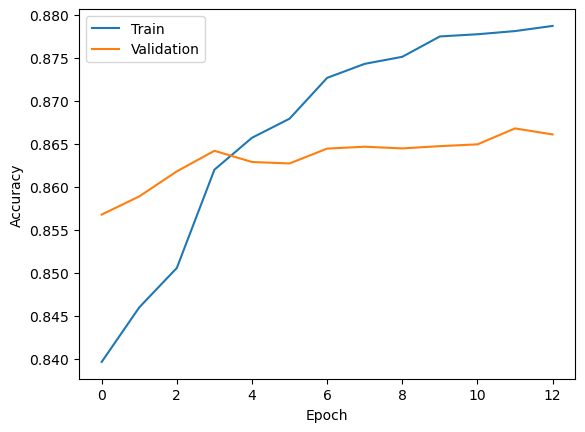

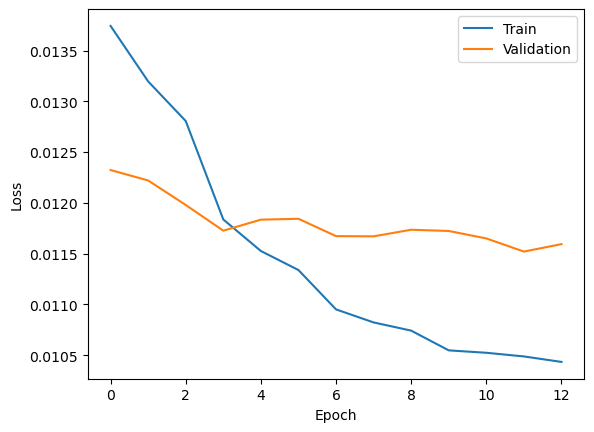

In [87]:
plot(train_accs, train_losses, val_accs, val_losses)